In [61]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import benchmark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
_FIG_SIZE=(6,5)
# _FNAME_SUFFIX = "hector_second_run_my_run"
# _FNAME_SUFFIX = "hector_second_run_my_run"
_FNAME_SUFFIX = "hector_nice-15"

# from condensed_sparsity.models import LinearCondensed


In [62]:
import pickle
threads = 4
device = "cpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)


[--------------------------------------------------------------------------------- Sparsity 99 with 4 threads using compilation strategy inductor and dtype torch.float32 on device cpu. ---------------------------------------------------------------------------------]
                     |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  csr only compiled with backend - inductor  |  Fine-grained + structured with backend inductor
4 threads: ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      2048   x 3072  |                     13379.9                     |                        10841.6                         |                  7207.2                  |                    7298

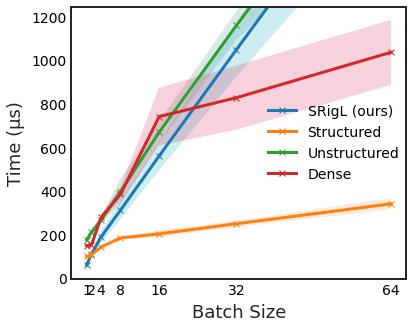

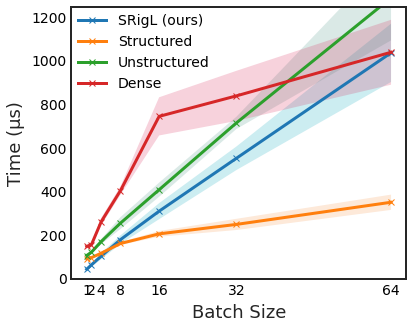

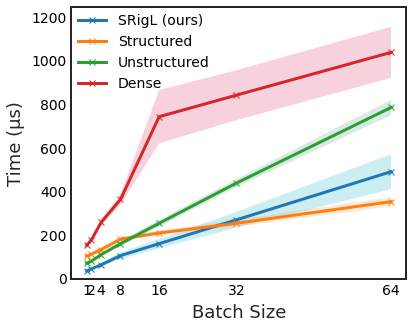

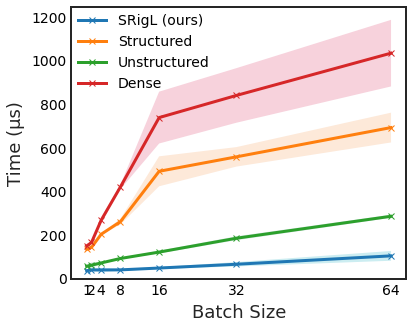

In [63]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [4,]:
# threads = 2
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    # fig, axs = plt.subplots(2, 2)
    # ax_idx = 0
    # row_idx = 0
    for _sparsity in [80, 90, 95, 99]:
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": [],
            'times': []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
            data["times"].append([t*1e6 for t in measurement.times])
        df = pd.DataFrame(data)
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=64
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    ax.fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        plt.ylim(top=_y_lim, bottom=0)
        plt.legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        ax.set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
        plt.show()
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.png", dpi=400, transparent=False)
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.pdf", dpi=600, transparent=False)


In [64]:
import copy
def remove_outliers(df, drop_over=None):
    df = copy.deepcopy(df)
    if drop_over is None:
        drop_over = np.inf
    for i, row in df.iterrows():
        q75, q25 = np.percentile(row["times"], [75 ,25])
        # q75, q25 = np.percentile(row["times"], [49, 50])
        iqr = q75 - q25
        org_median = row["time"]
        org_std = row["std"]
        updated_times = [t for t in row["times"] if (t < 1.5*iqr+q75) or (t > q25-1.5*iqr)]
        # updated_times = [t for ii,t in enumerate(row["times"]) if ii >=3]
        updated_times = [t for t in updated_times if t < drop_over]
        updated_std = np.std(updated_times)
        updated_time = np.median(updated_times)
        if len(row['times']) != len(updated_times):
            print(f"dropped {len(row['times'])-len(updated_times)} times")
            print(f"ORIG STD: {org_std}, updated: {updated_std}")
            print(f"Old times: {row['times']}")
            print(f"Updated times: {updated_times}")
        df.loc[i,"std"] = updated_std
        df.loc[i,"time"] = updated_time
        try:
            df.at[i,"times"] = updated_times
        except:
            print(updated_times)
            # print(f"Updated median: {org_median} -> {df.iloc[i]['time']}, {updated_time}")
            # print(f"Updated std: {org_std} -> {df.iloc[i]['std']}")
            # print(f"iqr: {iqr}")
    return df


In [65]:
df_ro = remove_outliers(df, drop_over=None)

Plotting 0, 0
max std: 2385.43198813608
max std: 2385.43198813608
Plotting 0, 1
max std: 2370.005723419808
max std: 2370.0057234198084
Plotting 1, 0
max std: 1423.6648764701877


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


max std: 1423.6648764701877
Plotting 1, 1
max std: 1249.16388372626
max std: 1249.16388372626


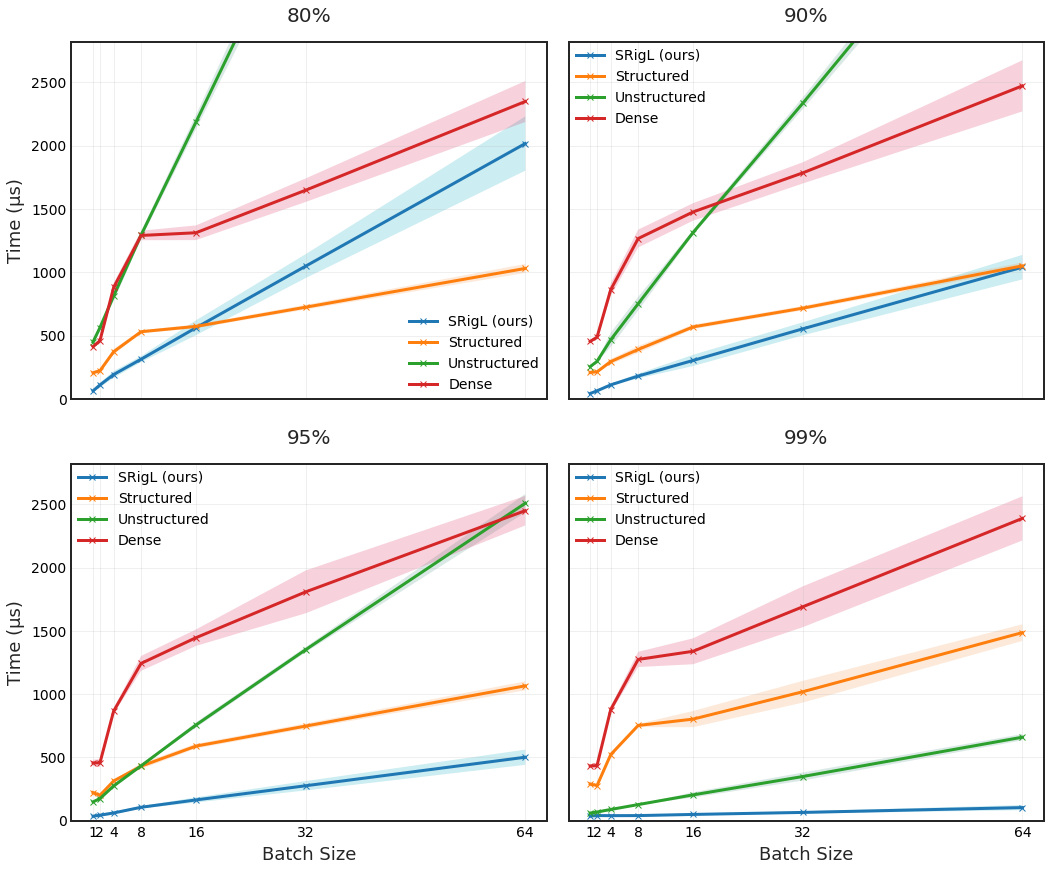

Plotting 0, 0
max std: 5933.72112855423
max std: 5933.721128554229
Plotting 0, 1
max std: 3212.994353772756
max std: 3212.994353772755
Plotting 1, 0
max std: 1937.4478124229315
max std: 1937.4478124229317
Plotting 1, 1
max std: 1160.3731435070597
max std: 1160.3731435070597


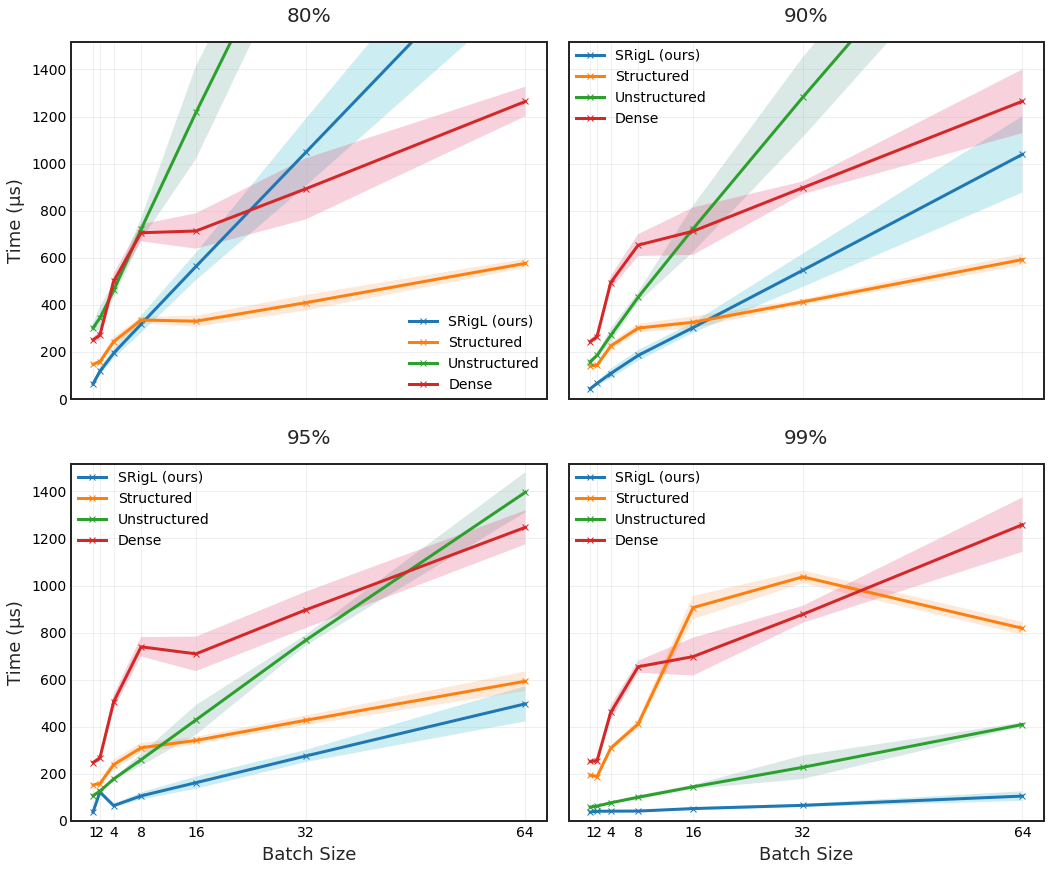

Plotting 0, 0
max std: 4588.020955609059
max std: 4588.020955609059
Plotting 0, 1
max std: 3211.8921508066883
max std: 3211.8921508066887
Plotting 1, 0
max std: 2406.2340114963054
max std: 2406.234011496305
Plotting 1, 1
max std: 1042.3721254062266
max std: 1042.3721254062266


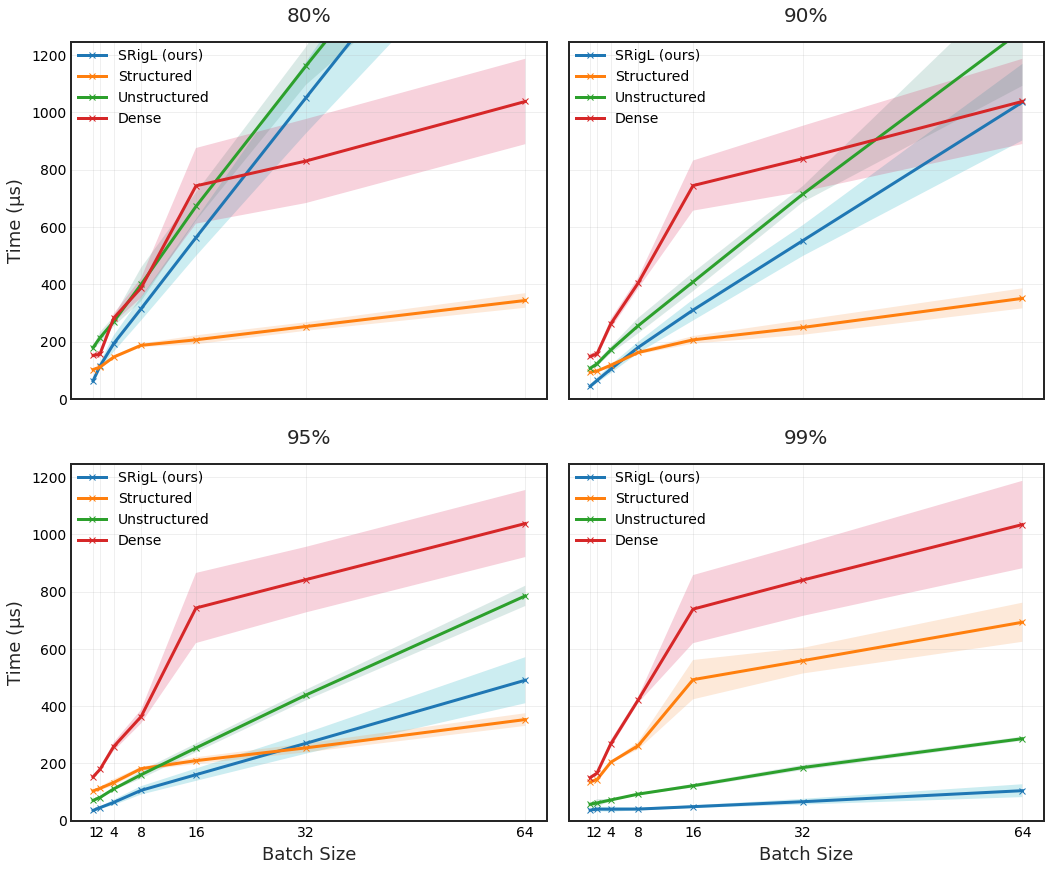

Plotting 0, 0
max std: 1751.5472210069827
max std: 1751.5472210069831
Plotting 0, 1
max std: 2573.1895035500474
max std: 2573.189503550047
Plotting 1, 0
max std: 794.5173527052019
max std: 794.5173527052019
Plotting 1, 1
max std: 662.3999878139556
max std: 662.3999878139556


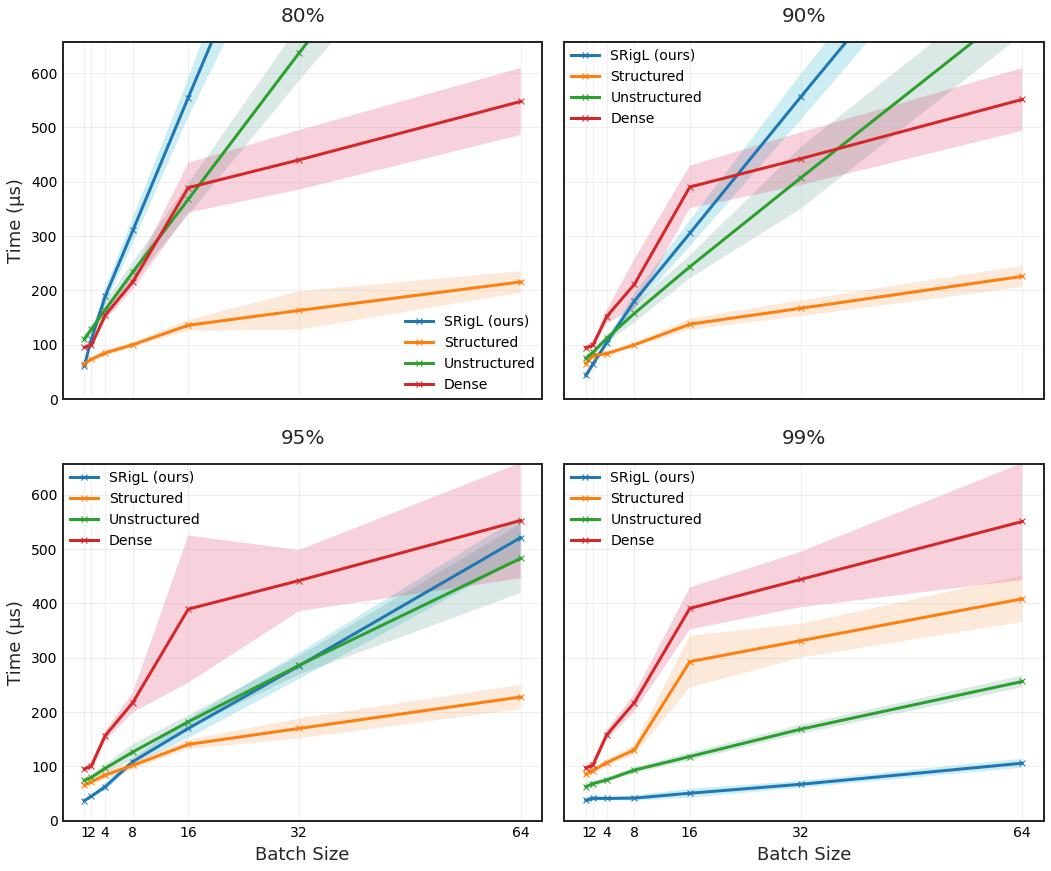

Plotting 0, 0
max std: 20997.341549674195
max std: 20997.341549674198
Plotting 0, 1
max std: 5705.635935520482
max std: 5705.635935520482
Plotting 1, 0
max std: 4652.975126234621
max std: 4652.975126234621
Plotting 1, 1
max std: 4170.483564967017
max std: 4170.483564967016


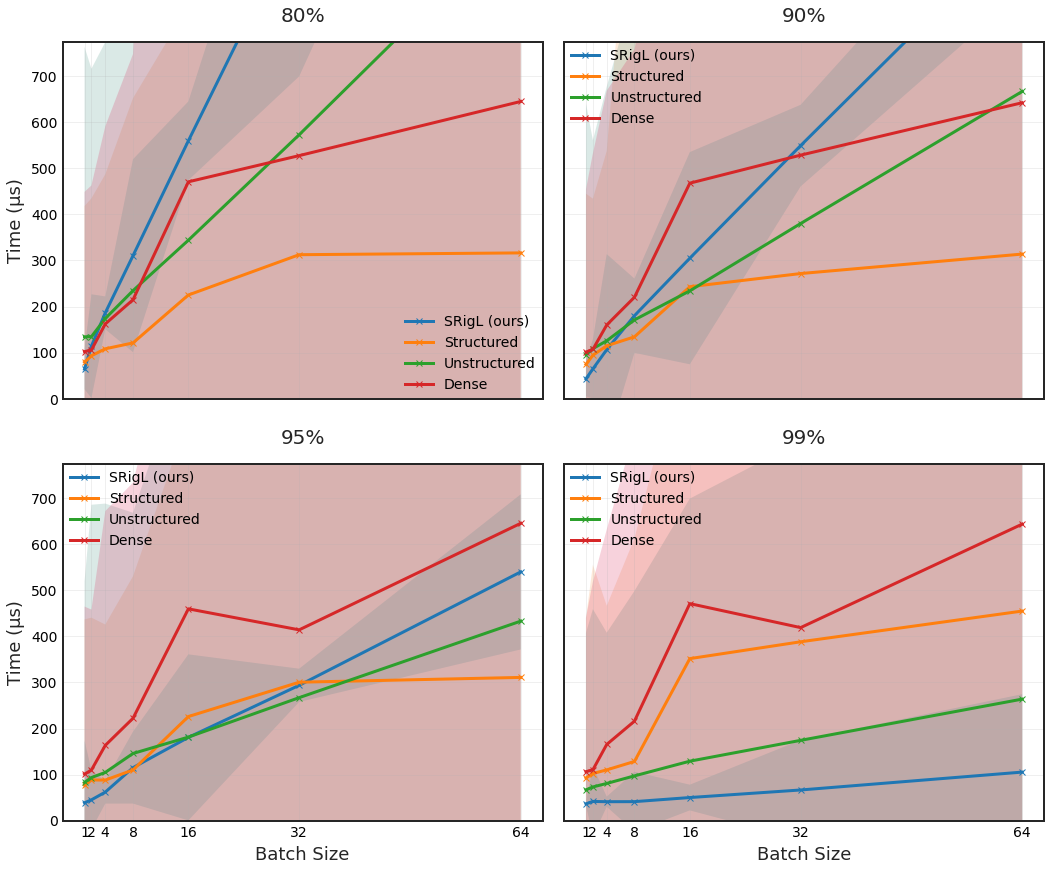

In [66]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [1,2,4,8,16]:
# threads = 2
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    fig, axs = plt.subplots(2, 2, figsize=[f * 2.5 for f in _FIG_SIZE],sharex=True, sharey=True)
    col_idx = 0
    row_idx = 0
    for _s_idx,_sparsity in enumerate([80, 90, 95, 99]):
        col_idx = 0
        if _s_idx > 1:
            row_idx = 1
        if _s_idx % 2 != 0:
            col_idx = 1
        print(f"Plotting {row_idx}, {col_idx}")
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": [],
            "times": []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
            data["times"].append([t*1e6 for t in measurement.times])
        df = pd.DataFrame(data)
        print(f"max std: {df['std'].max()}")
        df = remove_outliers(df)
        print(f"max std: {df['std'].max()}")
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        # fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=64
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    axs[row_idx, col_idx].plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    axs[row_idx, col_idx].fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        axs[row_idx, col_idx].set_ylim(top=_y_lim, bottom=0)
        axs[row_idx, col_idx].legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        axs[row_idx, col_idx].set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # axs[row_idx, col_idx].set_title(f"Sparsity {_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].set_title(f"{_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].grid(True, alpha=0.25)
        
    for ax in axs.flat:
        ax.set(xlabel="Batch Size", ylabel="Time (\u03bcs)")

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

        
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
    plt.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"../figs/multi_plot_threads-{threads}.png", dpi=400, transparent=False)
    fig.savefig(f"../figs/multi_plot_threads-{threads}.pdf", dpi=600, transparent=False)


In [67]:
# import re
# import pandas as pd
# import numpy as np
# plt.style.use("../plt_plot_style.mplstyle")


# import pickle
# for threads in [1,2,4,8,]:
#     device = "cpu"``
#     compiler = "inductor"
#     dtype="torch.float32"
#     file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_hector_second_run.pkl"
#     with open(f"../{file_name}", "rb") as handle:
#         compare = pickle.load(handle)
#     # print(compare)

#     _y_lim = None
#     for _sparsity in [80, 90, 95, 99]:
#         data = {
#             "sparsity": [],
#             "batch_size": [],
#             "num_features": [],
#             "time": [],
#             "std": [],
#             "description": [],
#             "times":[]
#         }
#         # _sparsity = 99
#         for measurement in compare._results:
#             sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
#             sparsity = sparsity_match.groups()[0]

#             thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
#             threads = thread_match.groups()[0]
#             desc = measurement.description
#             if int(sparsity) not in [_sparsity,]:
#                 continue
#             if desc not in target_descriptions.keys():
#                 continue
#             # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
#             #     continue
#             data["description"].append(target_descriptions[desc])
#             data["sparsity"].append(int(sparsity))
#             batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
#             data["batch_size"].append(int(batch))
#             data["num_features"].append(int(num_features))
#             data["time"].append(measurement.median*1e6)
#             data["times"].append([t*1e6 for t in measurement.times])
#             data["std"].append(np.std(measurement.times)*1e6)

#         df = pd.DataFrame(data)
#         df = df.sort_values(by="batch_size", ascending=True)
#         fig, ax = plt.subplots(figsize=_FIG_SIZE)
#         df = df.loc[df["batch_size"]<=64]  # TODO: Also sort by desc?
#         lines = ["solid", "dashed", "dashdot", "dotted"]
#         colours = ["red", "green", "blue", "orange"]
#         df_slice = df.loc[(df["sparsity"] == _sparsity) & (df["batch_size"]==1)]
#         ax.boxplot(df_slice["times"], labels=df_slice["description"])

#         # # for i, d in enumerate(df["description"].unique()):
#         #     colour = colours[i]
#         #     df_slice = df.loc[(df["sparsity"] == _sparsity) & (df["description"]==d) & (df["batch_size"]==1)]
#         #     # ax.boxplot(df_slice["times"], label=f"{d}", marker="x", color=colour)
#         #     ax.boxplot(df_slice["times"])
#         y_max = df.loc[(df["batch_size"]==1)]["time"].max() 
#         if _y_lim is None:
#             _y_lim = y_max + y_max * 0.2
#         plt.ylim(top=_y_lim, bottom=0)
#         plt.legend()
#         plt.ylabel("Time (\u03bc s)")
#         plt.xlabel("Batch Size")
#         # plt.grid(True, which="both")

#         plt.title(f"{_sparsity}% sparsity {threads} threads")
#         # ax.set_xscale("log")
#         # ax.set_yscale("log")
#         plt.show()
#         fig.savefig(f"../figs/single-sample-threads-{threads}-sparsity-{_sparsity}.png", dpi=400, transparent=False)


In [68]:
target_descriptions.values()


dict_values(['SRigL (ours)', 'Structured', 'Unstructured', 'Dense'])

In [69]:
from math import log
def get_asterix_y(df, sparsity): 
    base_time = df.loc[(df["sparsity"]==sparsity) & (df["description"]=="Structured")]['time'].item()
    return 12.5*(1+base_time//12.5)
    return base_time
    exp = log(base_time*10)//log(10)
    coeff_est = base_time / 10**exp
    coeffs = np.arange(0.0, 1.2, 0.2)
    for ii, res in enumerate([coeff_est - x for x in coeffs]):
        if res < 0:
            break
    return coeffs[ii]*10**exp

148


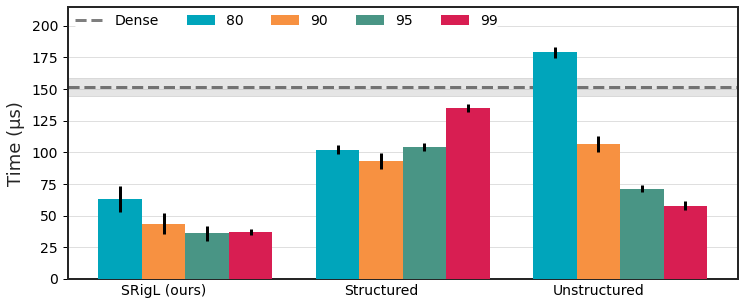

In [70]:
import re
import pandas as pd
import numpy as np
plt.style.use("./plt_plot_style_y_ticks.mplstyle")


import pickle
# for threads in [1,2,4,8,16]:
for threads in [4,]:
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"    
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)


    data = {
        "sparsity": [],
        "batch_size": [],
        "num_features": [],
        "time": [],
        "std": [],
        "description": [],
        "times":[]
    }
    for measurement in compare._results:
        sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
        sparsity = sparsity_match.groups()[0]

        thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
        threads = thread_match.groups()[0]
        desc = measurement.description
        if desc not in target_descriptions.keys():
            continue
        data["description"].append(target_descriptions[desc])
        data["sparsity"].append(int(sparsity))
        batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
        data["batch_size"].append(int(batch))
        data["num_features"].append(int(num_features))
        data["time"].append(measurement.median*1e6)
        data["times"].append([t*1e6 for t in measurement.times])
        data["std"].append(np.std(measurement.times)*1e6)


    df = pd.DataFrame(data)
    df = df.reset_index()
    df = df.loc[df["batch_size"]==1].reset_index()
    # if threads == "16":
    # break

    min_runs = np.inf
    for t in df['times']:
        if len(t)<min_runs:
            min_runs=len(t)
    print(min_runs)
    _DESC_ORDER = list(target_descriptions.values())
    df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
    df = df.sort_values(by="batch_size", ascending=True)
    x = np.arange(3)  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2, _FIG_SIZE[1]))  
    df_one_sample = df.loc[(df["batch_size"]==1) & (df["description"]!="Dense")]
    df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
    for sparsity in [ 80, 90, 95, 99]:
        df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
        offset = width * multiplier
        rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"], zorder=3)
        multiplier += 1
    dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["time"].item()
    std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["std"].item()
    plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
    # plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")
    
    ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
    # _alpha=0.2
    # plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
    # plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
    ax.set_ylabel('Time (\u03bcs)')
    ax.set_xticks(x + width, _DESC_ORDER[:-1])
    # ax.legend(title="Sparsity", loc='upper left', ncol=5)
    # ax.legend(loc='upper left', ncol=5, frameon=True)
    leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
    leg.get_frame().set_linewidth(0.0)
    y_max = df.loc[(df["batch_size"]==1)]["time"].max() 
    y_lim = y_max + y_max*0.2
    # y_lim = dense_time + dense_time * 0.2
    plt.ylim(top=y_lim, bottom=0)
    # plt.ylim(top=200, bottom=0)
    # ax.set_xlim=([0,2])
    ax.margins(0)  
    ax.grid(axis="y", alpha=0.5, which="both", zorder=0)
    y_marker_95 = get_asterix_y(df_one_sample, 95)
    y_marker_99 = get_asterix_y(df_one_sample, 99)
    # ax.plot([1.4], [y_marker_95], marker=r"$\dagger$", color='#2ca02c', markersize=10, zorder=10)
    # ax.plot([1.6], [y_marker_99], marker=r"$\dagger$", markersize=10, color='#d62728', zorder=10)
    # plt.tight_layout(pad=0,h_patimes[c]ds")
    fig.savefig(f"../figs/grouped-bar-threads-{threads}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../figs/grouped-bar-threads-{threads}.pdf", dpi=600, bbox_inches="tight")


In [71]:
print(_COLOURS)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [72]:
df_one_sample

level_0  index  sparsity  batch_size  num_features        time        std  \
3        47     47        99           1          3072   37.045488   2.420081   
7        95     95        95           1          3072   36.002081   5.746367   
11      143    143        90           1          3072   43.641233   8.342928   
15      191    191        80           1          3072   63.120499  10.245474   
1        45     45        99           1          3072  135.278504   3.080306   
5        93     93        95           1          3072  104.153487   2.974038   
9       141    141        90           1          3072   92.932321   6.139247   
13      189    189        80           1          3072  102.201477   3.189932   
2        46     46        99           1          3072   57.694542   3.632514   
6        94     94        95           1          3072   71.219341   2.543072   
10      142    142        90           1          3072  106.710414   6.166315   
14      190    190        80           1          3072  179.032516   4.569382   

     description                                              times  
3   SRigL (ours)  [38.45529165118933, 37.39519044756889, 37.6954...  
7   SRigL (ours)  [51.08066834509373, 43.48341841250658, 43.1879...  
11  SRigL (ours)  [71.7994524165988, 65.1720305904746, 64.302911...  
15  SRigL (ours)  [93.38623378425837, 88.75475730746984, 89.1753...  
1     Structured  [142.8466895595193, 143.2466134428978, 160.628...  
5     Structured  [106.53196834027767, 105.24667333811522, 105.3...  
9     Structured  [106.87918402254581, 105.36819230765104, 106.3...  
13    Structured  [103.6243187263608, 103.13489940017462, 103.38...  
2   Unstructured  [66.46252702921629, 65.15071261674166, 64.6910...  
6   Unstructured  [76.23071316629648, 72.4273594096303, 72.07529...  
10  Unstructured  [120.52574194967747, 119.03688311576843, 152.6...  
14  Unstructured  [239.36079815030098, 226.27990692853928, 223.4...

In [73]:
get_asterix_y(df_one_sample, 95)

112.5

In [74]:
df.loc[(df["sparsity"]==90) & (df["batch_size"]==1) & (df["description"]=="SRigL (ours)")]['time']

11    43.641233
Name: time, dtype: float64

In [75]:
times = {
    "SRigL (ours)": None,
    "Unstructured": None,
    "Structured": None,
    "Dense": None,
}
for desc in times.keys():
    times[desc] = df.loc[(df["sparsity"]==90) & (df["batch_size"]==1) & (df["description"]==desc)]['time'].item()

for c in ["Unstructured", "Dense", "Structured"]:
    print(f"{c}: {times[c]/times['SRigL (ours)']}")

Unstructured: 2.4451741210824913
Dense: 3.396082014890604
Structured: 2.1294613830827074


3


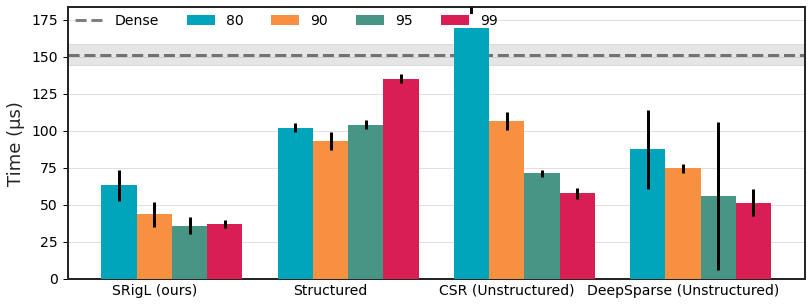

In [76]:
import re
import pandas as pd
import numpy as np
plt.style.use("./plt_plot_style_y_ticks.mplstyle")
# plt.style.use("default")

# deep sparse
deepsparse_target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    # "DeepSparse - Unstructured - SRigL": "DeepSparse (SRigL)",
    # "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    # "csr only compiled with backend - inductor": "Unstructured",
    "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    "csr only compiled with backend - inductor": "CSR (Unstructured)",
    "DeepSparse - Unstructured": "DeepSparse (Unstructured)",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}

suffixes = ["-deepsparse-final_hector_nice-15", f"final_{_FNAME_SUFFIX}"]
import pickle
# for threads in [1,2,4,8,16]:
batch_size=1
threads=4
device = "cpu"
compiler = "inductor"
dtype="torch.float32"
# batch_size=2048
comparisons = {}
for s in suffixes:
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}{s}.pkl"  
    with open(f"../{file_name}", "rb") as handle:
        comparisons[s] = pickle.load(handle)


data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": [],
    "times":[]
}
deep_s = False
for s, compare  in comparisons.items():
    if "deepsparse" in s:
        deep_s = True
    else:
        deep_s = False
    for measurement in compare._results:
        desc = measurement.description
        # print(desc)
        if deep_s and "DeepSparse - Unstructured" not in desc:
            continue
        sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
        sparsity = sparsity_match.groups()[0]

        thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
        threads = thread_match.groups()[0]
        desc = measurement.description
        if desc not in deepsparse_target_descriptions.keys():
            continue
        data["description"].append(deepsparse_target_descriptions[desc])
        data["sparsity"].append(int(sparsity))
        batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
        data["batch_size"].append(int(batch))
        data["num_features"].append(int(num_features))
        data["time"].append(measurement.median*1e6)
        data["times"].append([t*1e6 for t in measurement.times])
        data["std"].append(np.std(measurement.times)*1e6)


df = pd.DataFrame(data)
df = df.reset_index()
df = df.loc[df["batch_size"]==batch_size].reset_index()
# if threads == "16":

min_runs = np.inf
for t in df['times']:
    if len(t)<min_runs:
        min_runs=len(t)
print(min_runs)
_DESC_ORDER = list(deepsparse_target_descriptions.values())
df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
df = df.sort_values(by="batch_size", ascending=True)
df = remove_outliers(df=df, drop_over=None)
x = np.arange(4)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2.2, _FIG_SIZE[1]))  
df_one_sample = df.loc[(df["batch_size"]==batch_size) & (df["description"]!="Dense")]
df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
for sparsity in [ 80, 90,95,99]:
    df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
    offset = width * multiplier
    rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"], zorder=3)
    multiplier += 1
dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["time"].item()
std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["std"].item()
plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
# plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")

ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
# _alpha=0.2
# plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
# plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
ax.set_ylabel('Time (\u03bcs)')
ax.set_xticks(x + width, _DESC_ORDER[:-1])
# ax.legend(title="Sparsity", loc='upper left', ncol=5)
# ax.legend(loc='upper left', ncol=5, frameon=True)
leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
leg.get_frame().set_linewidth(0.0)
y_max = df.loc[(df["batch_size"]==batch_size)]["time"].max() 
y_lim = y_max + y_max*0.2
# y_lim = dense_time + dense_time * 0.2
# plt.ylim(top=y_lim, bottom=0)
# plt.ylim(top=200, bottom=0)
# ax.set_xlim=([0,2])
ax.margins(0)  
# plt.yaxis*()
# plt.tight_layout(pad=0,h_pad=0)
# plt.grid(axis="y", alpha=0.4)
plt.grid(axis="y", alpha=0.25)


fig.show()
# ax.set_yscale("log")
# plt.yscale("log")
# plt.tick_params(axis='y', which="minor")
# import matplotlib

# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=5) 
# ax.yaxis.set_major_locator(locmaj)

# locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=5)
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.tick_params(axis='both', which="both", reset=True)
# ax.minorticks_on()
# ax.set_yticks([10**i for i in range(5)], size=300, width=300)
# ax.set_yticks([x*10**i for i in range(5) for x in [0.2, 0.4, 0.6, 0.8]], minor=True, size=300, width=100, direction="inout",)
ax.grid(axis="y", alpha=0.5, which="both", zorder=0)
# plt.grid(True, alpha=0.25)    # plt.title(f"{threads} threads")
fig.savefig(f"../figs/deepsparse-grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"../figs/deepsparse-grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}.pdf", dpi=600, bbox_inches="tight")


In [77]:
srigl_80_times = df.loc[(df["description"]=="SRigL (ours)") & (df["sparsity"]==80)]['times'].item()

In [78]:
ds_80_times = df.loc[(df["description"]=="DeepSparse (Unstructured)") & (df["sparsity"]==80)]['times'].item()

In [79]:
len(srigl_80_times)

295

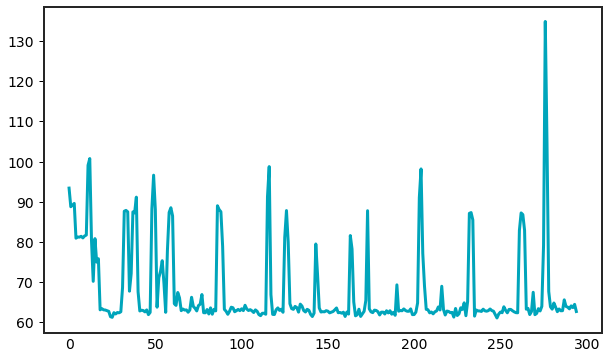

In [80]:
plt.plot(srigl_80_times)

In [81]:
pd.Series(ds_80_times).median()

87.58479920215905

In [82]:
pd.Series(srigl_80_times).median()

63.120499253273

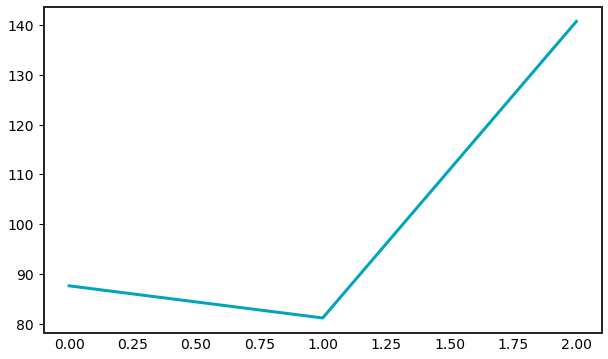

In [83]:
plt.plot(ds_80_times)

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 81.12074961,  87.08164828,  93.04254695,  99.00344562,
        104.96434429, 110.92524296, 116.88614163, 122.8470403 ,
        128.80793897, 134.76883763, 140.7297363 ]),
 <BarContainer object of 10 artists>)

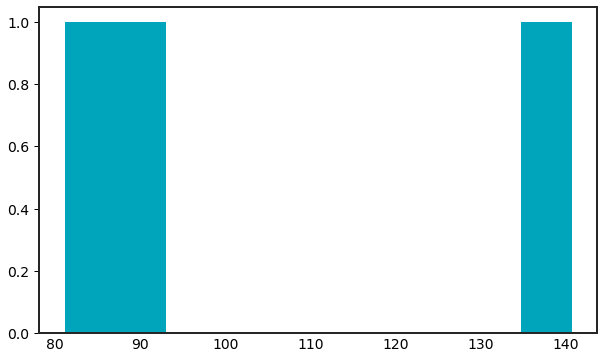

In [84]:
plt.hist(x=df.loc[(df["description"]=="DeepSparse (Unstructured)") & (df["sparsity"]==80)]['times'])

In [85]:
dense_time

151.40310861170292

In [86]:
df

level_0  index  sparsity  batch_size  num_features        time        std  \
0         0      0        99           1          3072   51.478755   8.849967   
17      193    193        80           1          3072  102.201477   3.189932   
16      192    192        80           1          3072  151.403109   6.926749   
15      147    147        90           1          3072   43.641233   8.342928   
14      146    146        90           1          3072  106.710414   6.166315   
13      145    145        90           1          3072   92.932321   6.139247   
12      144    144        90           1          3072  148.209208   9.099865   
11       99     99        95           1          3072   36.002081   5.746367   
10       98     98        95           1          3072   71.219341   2.543072   
9        97     97        95           1          3072  104.153487   2.974038   
8        96     96        95           1          3072  153.095881   6.127175   
7        51     51        99           1          3072   37.045488   2.420081   
6        50     50        99           1          3072   57.694542   3.632514   
5        49     49        99           1          3072  135.278504   3.080306   
4        48     48        99           1          3072  150.551531   8.318783   
3         3      3        80           1          3072   87.584799  26.707052   
2         2      2        90           1          3072   74.517419   2.985193   
1         1      1        95           1          3072   55.878550  49.836744   
18      194    194        80           1          3072  179.032516   4.569382   
19      195    195        80           1          3072   63.120499  10.245474   

                  description  \
0   DeepSparse (Unstructured)   
17                 Structured   
16                      Dense   
15               SRigL (ours)   
14         CSR (Unstructured)   
13                 Structured   
12                      Dense   
11               SRigL (ours)   
10         CSR (Unstructured)   
9                  Structured   
8                       Dense   
7                SRigL (ours)   
6          CSR (Unstructured)   
5                  Structured   
4                       Dense   
3   DeepSparse (Unstructured)   
2   DeepSparse (Unstructured)   
1   DeepSparse (Unstructured)   
18         CSR (Unstructured)   
19               SRigL (ours)   

                                                times  
0   [46.37942269910127, 61.05503579601645, 38.3350...  
17  [103.6243187263608, 103.13489940017462, 103.38...  
16  [235.44062860310078, 235.5668693780899, 234.32...  
15  [71.7994524165988, 65.1720305904746, 64.302911...  
14  [120.52574194967747, 119.03688311576843, 152.6...  
13  [106.87918402254581, 105.36819230765104, 106.3...  
12  [241.7030744254589, 233.69579575955868, 209.93...  
11  [51.08066834509373, 43.48341841250658, 43.1879...  
10  [76.23071316629648, 72.4273594096303, 72.07529...  
9   [106.53196834027767, 105.24667333811522, 105.3...  
8   [242.4126025289297, 233.745900914073, 235.3335...  
7   [38.45529165118933, 37.39519044756889, 37.6954...  
6   [66.46252702921629, 65.15071261674166, 64.6910...  
5   [142.8466895595193, 143.2466134428978, 160.628...  
4   [239.17388170957565, 239.05420675873756, 236.9...  
3   [87.58479920215905, 81.12074960954487, 140.729...  
2   [77.23701021168381, 69.99894380569458, 74.5174...  
1   [56.48127989843488, 53.3730189781636, 179.3227...  
18  [239.36079815030098, 226.27990692853928, 223.4...  
19  [93.38623378425837, 88.75475730746984, 89.1753...

Dense benchmark - Compiled - backend inductor
FFI
FFI TP
FFI TP (self)
Structured sparsity compiled with backend - inductor
DeepSparse - Unstructured
DeepSparse - Structured
DeepSparse - SRigL
structured + csr with backend inductor
csr only compiled with backend - inductor
Fine-grained + structured with backend inductor
Dense benchmark - Compiled - backend inductor
FFI
FFI TP
FFI TP (self)
Structured sparsity compiled with backend - inductor
DeepSparse - Unstructured
DeepSparse - Structured
DeepSparse - SRigL
structured + csr with backend inductor
csr only compiled with backend - inductor
Fine-grained + structured with backend inductor
Dense benchmark - Compiled - backend inductor
FFI
FFI TP
FFI TP (self)
Structured sparsity compiled with backend - inductor
DeepSparse - Unstructured
DeepSparse - Structured
DeepSparse - SRigL
structured + csr with backend inductor
csr only compiled with backend - inductor
Fine-grained + structured with backend inductor
Dense benchmark - Compiled - backe

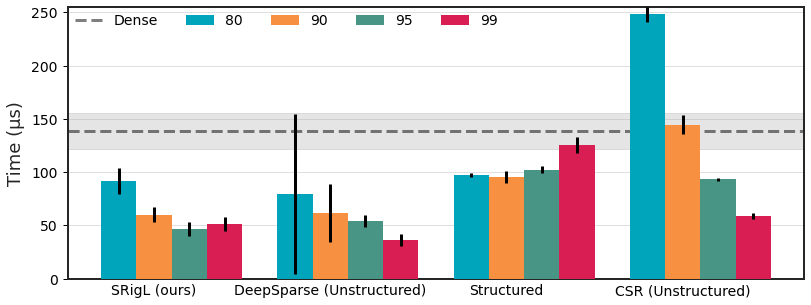

In [107]:
## deep sparse full run
fname = 'benchmark_v2_cpu_threads_4_compiler_inductor_dtype_torch.float32-deepsparse-final_hector_nice-15_int32_idx_v3'


import re
import pandas as pd
import numpy as np
import pickle
plt.style.use("./plt_plot_style_y_ticks.mplstyle")
# plt.style.use("default")

# deep sparse
deepsparse_target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    "DeepSparse - Unstructured": "DeepSparse (Unstructured)",
    # "DeepSparse - Unstructured - SRigL": "DeepSparse (SRigL)",
    # "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    # "csr only compiled with backend - inductor": "Unstructured",
    "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    "csr only compiled with backend - inductor": "CSR (Unstructured)",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}

# suffixes = ["-deepsparse-final_hector_nice-15_int32_idx_v3'", f"final_{_FNAME_SUFFIX}"]
# suffixes = ["-deepsparse-final_hector_nice-15_int32_idx_v3", "-deepsparse-final_hector_nice-15_int32_idx_v3"]
suffix = "-deepsparse-final_hector_nice-15_int32_idx_v3"
# for threads in [1,2,4,8,16]:
batch_size=1
threads=4
device = "cpu"
compiler = "inductor"
dtype="torch.float32"
# batch_size=2048

file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}{suffix}.pkl"  
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)


data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": [],
    "times":[],
    "mean":[]
}
for measurement in compare._results:
    desc = measurement.description
    print(desc)
    sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
    sparsity = sparsity_match.groups()[0]
    thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
    threads = thread_match.groups()[0]
    desc = measurement.description
    if desc not in deepsparse_target_descriptions.keys():
        continue
    data["description"].append(deepsparse_target_descriptions[desc])
    data["sparsity"].append(int(sparsity))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["times"].append([t*1e6 for t in measurement.times])
    data['mean'].append(pd.Series([t*1e6 for t in measurement.times]).mean())
    data["std"].append(np.std(measurement.times)*1e6)


df = pd.DataFrame(data)
df = df.reset_index()
df = df.loc[df["batch_size"]==batch_size].reset_index()
# if threads == "16":

min_runs = np.inf
for t in df['times']:
    if len(t)<min_runs:
        min_runs=len(t)
print(min_runs)
_DESC_ORDER = list(deepsparse_target_descriptions.values())
df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
df = df.sort_values(by="batch_size", ascending=True)
df = remove_outliers(df, drop_over=9000)
x = np.arange(4)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2.2, _FIG_SIZE[1]))  
df_one_sample = df.loc[(df["batch_size"]==batch_size) & (df["description"]!="Dense")]
df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
for sparsity in [ 80, 90,95,99]:
    df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
    offset = width * multiplier
    rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"], zorder=3)
    multiplier += 1
dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["time"].item()
std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["std"].item()
plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
# plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")

ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
# _alpha=0.2
# plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
# plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
ax.set_ylabel('Time (\u03bcs)')
ax.set_xticks(x + width, _DESC_ORDER[:-1])
# ax.legend(title="Sparsity", loc='upper left', ncol=5)
# ax.legend(loc='upper left', ncol=5, frameon=True)
leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
leg.get_frame().set_linewidth(0.0)
y_max = df.loc[(df["batch_size"]==batch_size)]["time"].max() 
y_lim = y_max + y_max*0.2
# y_lim = dense_time + dense_time * 0.2
# plt.ylim(top=y_lim, bottom=0)
# plt.ylim(top=200, bottom=0)
# ax.set_xlim=([0,2])
ax.margins(0)  
# plt.yaxis*()
# plt.tight_layout(pad=0,h_pad=0)
# plt.grid(axis="y", alpha=0.4)
plt.grid(axis="y", alpha=0.25)


fig.show()
# ax.set_yscale("log")
# plt.yscale("log")
# plt.tick_params(axis='y', which="minor")
# import matplotlib

# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=5) 
# ax.yaxis.set_major_locator(locmaj)

# locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=5)
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.tick_params(axis='both', which="both", reset=True)
# ax.minorticks_on()
# ax.set_yticks([10**i for i in range(5)], size=300, width=300)
# ax.set_yticks([x*10**i for i in range(5) for x in [0.2, 0.4, 0.6, 0.8]], minor=True, size=300, width=100, direction="inout",)
ax.grid(axis="y", alpha=0.5, which="both", zorder=0)
# plt.grid(True, alpha=0.25)    # plt.title(f"{threads} threads")
fig.savefig(f"../figs/deepsparse-grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}-all-benchmark.png", dpi=600, bbox_inches="tight")
fig.savefig(f"../figs/deepsparse-grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}-all-benchmark.pdf", dpi=600, bbox_inches="tight")



In [88]:
df.loc[df['description'].isin(["DeepSparse (Unstructured)", "SRigL (ours)"])][['description', 'sparsity', 'mean']]

description  sparsity        mean
17  DeepSparse (Unstructured)        80  107.576217
14               SRigL (ours)        90   62.316521
12  DeepSparse (Unstructured)        90   73.578320
9                SRigL (ours)        95   48.072093
7   DeepSparse (Unstructured)        95   69.384376
4                SRigL (ours)        99   53.254698
2   DeepSparse (Unstructured)        99   49.822114
19               SRigL (ours)        80   95.165853

In [89]:
df_one_sample

level_0  index  sparsity  batch_size  num_features        time  \
14       14     14        90           1          3072   60.264330   
9         9      9        95           1          3072   46.492670   
4         4      4        99           1          3072   51.299545   
19       19     19        80           1          3072   91.742451   
16       16     16        80           1          3072   97.104450   
11       11     11        90           1          3072   95.566435   
6         6      6        95           1          3072  102.301790   
1         1      1        99           1          3072  125.617051   
13       13     13        90           1          3072  144.676899   
8         8      8        95           1          3072   93.135830   
3         3      3        99           1          3072   58.646390   
18       18     18        80           1          3072  247.899949   
17       17     17        80           1          3072   79.232996   
12       12     12        90           1          3072   62.034000   
7         7      7        95           1          3072   54.112985   
2         2      2        99           1          3072   36.363956   

            std                description  \
14     6.908938               SRigL (ours)   
9      6.568296               SRigL (ours)   
4      6.342770               SRigL (ours)   
19    12.632256               SRigL (ours)   
16     1.873436                 Structured   
11     5.613476                 Structured   
6      3.122214                 Structured   
1      7.784876                 Structured   
13     9.261050         CSR (Unstructured)   
8      1.640964         CSR (Unstructured)   
3      2.844882         CSR (Unstructured)   
18     6.995677         CSR (Unstructured)   
17  1058.734262  DeepSparse (Unstructured)   
12   675.122882  DeepSparse (Unstructured)   
7    741.430745  DeepSparse (Unstructured)   
2    763.462020  DeepSparse (Unstructured)   

                                                times        mean  
14  [79.95298015885055, 72.64351996127516, 71.7158...   62.316521  
9   [57.83598986454308, 52.68017004709691, 48.4317...   48.072093  
4   [54.907259764149785, 52.50771006103605, 52.668...   53.254698  
19  [208.59439973719418, 200.99760149605572, 202.1...   95.165853  
16  [99.52600987162441, 98.80981990136206, 99.0574...   97.361564  
11  [108.43909985851496, 108.28411963302642, 105.9...   97.090987  
6   [115.96997966989875, 114.51405007392168, 114.4...  103.032966  
1   [196.78769749589264, 194.11189714446664, 191.3...  127.092890  
13  [221.46900300867856, 197.20419659279287, 171.2...  147.399090  
8   [102.49358019791543, 94.63205002248287, 93.581...   93.592274  
3   [61.573359998874366, 60.860979720018804, 60.02...   59.133341  
18  [389.6291018463671, 333.2196967676282, 298.610...  248.808370  
17  [197.13002257049084, 105.93398474156857, 90.67...  107.576217  
12  [119.52401837334037, 76.80803537368774, 70.115...   73.578320  
7   [204.67402646318078, 116.87300866469741, 103.3...   69.384376  
2   [101.25100379809737, 46.001048758625984, 50.07...   49.822114

In [90]:
df.loc[(df["sparsity"]==90) & df["batch_size"]==1]


level_0  index  sparsity  batch_size  num_features        time  \
14       14     14        90           1          3072   60.264330   
13       13     13        90           1          3072  144.676899   
12       12     12        90           1          3072   62.034000   
11       11     11        90           1          3072   95.566435   
10       10     10        90           1          3072  147.699140   

           std                description  \
14    6.908938               SRigL (ours)   
13    9.261050         CSR (Unstructured)   
12  675.122882  DeepSparse (Unstructured)   
11    5.613476                 Structured   
10    6.130848                      Dense   

                                                times        mean  
14  [79.95298015885055, 72.64351996127516, 71.7158...   62.316521  
13  [221.46900300867856, 197.20419659279287, 171.2...  147.399090  
12  [119.52401837334037, 76.80803537368774, 70.115...   73.578320  
11  [108.43909985851496, 108.28411963302642, 105.9...   97.090987  
10  [160.53215018473566, 169.99659012071788, 152.7...  150.146329

In [91]:
for i, row in df.loc[(df["sparsity"]==95) & (df["batch_size"]==1)].iterrows():
    more_than_200 = [t for t in row["times"] if t > 200]
    print(len(more_than_200))


0
0
14
0
0


In [92]:
df


level_0  index  sparsity  batch_size  num_features        time  \
0         0      0        99           1          3072  147.213100   
17       17     17        80           1          3072   79.232996   
16       16     16        80           1          3072   97.104450   
15       15     15        80           1          3072  138.884800   
14       14     14        90           1          3072   60.264330   
13       13     13        90           1          3072  144.676899   
12       12     12        90           1          3072   62.034000   
11       11     11        90           1          3072   95.566435   
10       10     10        90           1          3072  147.699140   
9         9      9        95           1          3072   46.492670   
8         8      8        95           1          3072   93.135830   
7         7      7        95           1          3072   54.112985   
6         6      6        95           1          3072  102.301790   
5         5      5        95           1          3072  147.690660   
4         4      4        99           1          3072   51.299545   
3         3      3        99           1          3072   58.646390   
2         2      2        99           1          3072   36.363956   
1         1      1        99           1          3072  125.617051   
18       18     18        80           1          3072  247.899949   
19       19     19        80           1          3072   91.742451   

            std                description  \
0      5.909444                      Dense   
17  1058.734262  DeepSparse (Unstructured)   
16     1.873436                 Structured   
15    16.786395                      Dense   
14     6.908938               SRigL (ours)   
13     9.261050         CSR (Unstructured)   
12   675.122882  DeepSparse (Unstructured)   
11     5.613476                 Structured   
10     6.130848                      Dense   
9      6.568296               SRigL (ours)   
8      1.640964         CSR (Unstructured)   
7    741.430745  DeepSparse (Unstructured)   
6      3.122214                 Structured   
5      6.141657                      Dense   
4      6.342770               SRigL (ours)   
3      2.844882         CSR (Unstructured)   
2    763.462020  DeepSparse (Unstructured)   
1      7.784876                 Structured   
18     6.995677         CSR (Unstructured)   
19    12.632256               SRigL (ours)   

                                                times        mean  
0   [153.311729663983, 160.50420003011823, 165.999...  149.412795  
17  [197.13002257049084, 105.93398474156857, 90.67...  107.576217  
16  [99.52600987162441, 98.80981990136206, 99.0574...   97.361564  
15  [398.47579901106656, 261.09860045835376, 261.8...  142.446183  
14  [79.95298015885055, 72.64351996127516, 71.7158...   62.316521  
13  [221.46900300867856, 197.20419659279287, 171.2...  147.399090  
12  [119.52401837334037, 76.80803537368774, 70.115...   73.578320  
11  [108.43909985851496, 108.28411963302642, 105.9...   97.090987  
10  [160.53215018473566, 169.99659012071788, 152.7...  150.146329  
9   [57.83598986454308, 52.68017004709691, 48.4317...   48.072093  
8   [102.49358019791543, 94.63205002248287, 93.581...   93.592274  
7   [204.67402646318078, 116.87300866469741, 103.3...   69.384376  
6   [115.96997966989875, 114.51405007392168, 114.4...  103.032966  
5   [177.51535982824862, 182.75533977430314, 180.0...  149.145112  
4   [54.907259764149785, 52.50771006103605, 52.668...   53.254698  
3   [61.573359998874366, 60.860979720018804, 60.02...   59.133341  
2   [101.25100379809737, 46.001048758625984, 50.07...   49.822114  
1   [196.78769749589264, 194.11189714446664, 191.3...  127.092890  
18  [389.6291018463671, 333.2196967676282, 298.610...  248.808370  
19  [208.59439973719418, 200.99760149605572, 202.1...   95.165853

In [93]:
142.169371/36.942507	


3.8483953187042776

In [94]:
72.288010 / 36.942507


1.956770557017151

In [95]:
min_runs = 0
for t in df['times']:
    if len(t)>min_runs:
        min_runs=len(t)
print(min_runs)


40143


In [96]:
df['times']


0     [153.311729663983, 160.50420003011823, 165.999...
17    [197.13002257049084, 105.93398474156857, 90.67...
16    [99.52600987162441, 98.80981990136206, 99.0574...
15    [398.47579901106656, 261.09860045835376, 261.8...
14    [79.95298015885055, 72.64351996127516, 71.7158...
13    [221.46900300867856, 197.20419659279287, 171.2...
12    [119.52401837334037, 76.80803537368774, 70.115...
11    [108.43909985851496, 108.28411963302642, 105.9...
10    [160.53215018473566, 169.99659012071788, 152.7...
9     [57.83598986454308, 52.68017004709691, 48.4317...
8     [102.49358019791543, 94.63205002248287, 93.581...
7     [204.67402646318078, 116.87300866469741, 103.3...
6     [115.96997966989875, 114.51405007392168, 114.4...
5     [177.51535982824862, 182.75533977430314, 180.0...
4     [54.907259764149785, 52.50771006103605, 52.668...
3     [61.573359998874366, 60.860979720018804, 60.02...
2     [101.25100379809737, 46.001048758625984, 50.07...
1     [196.78769749589264, 194.11189714446664, 1

In [97]:
ax.get_xlim()


(-0.29000000000000004, 3.89)

In [98]:
df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["time"]


15    138.8848
Name: time, dtype: float64

In [99]:
df_slice = adf.loc[(df["batch_size"]==1) & (df["sparsity"]==80)].sort_values(by="time")
df_slice


NameError: name 'adf' is not defined

In [ ]:
df_slice


sparsity  batch_size  num_features        time        std  \
191        80           1          3072   65.143271   7.295133   
189        80           1          3072   66.409758   7.608274   
188        80           1          3072   96.018100   8.551347   
190        80           1          3072  113.703799  12.253186   

                 description  \
191  Struct. + Const. fan-in   
189             Struct. only   
188                    Dense   
190                      CSR   

                                                 times  
191  [83.1374991685152, 71.49433251470327, 82.84409...  
189  [68.66620853543282, 81.38469886034727, 98.4539...  
188  [116.68731458485126, 116.33289977908134, 116.6...  
190  [168.0694054812193, 169.08892430365086, 185.36...

In [ ]:
df_slice["description"] = pd.Categorical(df_slice["description"], categories=_DESC_ORDER)


In [ ]:
df_slice


sparsity  batch_size  num_features        time        std  \
191        80           1          3072   65.143271   7.295133   
189        80           1          3072   66.409758   7.608274   
188        80           1          3072   96.018100   8.551347   
190        80           1          3072  113.703799  12.253186   

                 description  \
191  Struct. + Const. fan-in   
189             Struct. only   
188                    Dense   
190                      CSR   

                                                 times  
191  [83.1374991685152, 71.49433251470327, 82.84409...  
189  [68.66620853543282, 81.38469886034727, 98.4539...  
188  [116.68731458485126, 116.33289977908134, 116.6...  
190  [168.0694054812193, 169.08892430365086, 185.36...

In [ ]:
def error_bar(df)


SyntaxError: expected ':' (3123403499.py, line 1)

In [ ]:
df


sparsity  batch_size  num_features          time          std  \
95         95           1          3072     36.167209     7.155722   
189        80           1          3072     66.409758     7.608274   
188        80           1          3072     96.018100     8.551347   
143        90           1          3072     43.218883     3.936562   
142        90           1          3072     74.157577     7.384433   
..        ...         ...           ...           ...          ...   
145        80        2048          3072   4091.660026   507.042419   
146        80        2048          3072  32193.977386  2771.154095   
147        80        2048          3072  61874.275794  2506.466313   
96         90        2048          3072   8210.071828   813.539853   
0          99        2048          3072   8211.981039   997.327098   

                        description  \
95   SRigL: Struct. + Const. fan-in   
189             SRigL: Struct. only   
188                           Dense   
143  SRigL: Struct. + Const. fan-in   
142                       RigL: CSR   
..                              ...   
145             SRigL: Struct. only   
146                       RigL: CSR   
147  SRigL: Struct. + Const. fan-in   
96                            Dense   
0                             Dense   

                                                 times  
95   [49.483818002045155, 43.286317959427834, 42.01...  
189  [68.66620853543282, 81.38469886034727, 98.4539...  
188  [116.68731458485126, 116.33289977908134, 116.6...  
143  [66.5759714320302, 53.861113265156746, 50.8129...  
142  [74.1732306778431, 74.03820753097534, 74.09465...  
..                                                 ...  
145  [5456.481594592333, 4281.3727632164955, 5051.9...  
146  [32116.779126226902, 32232.029363512993, 32061...  
147  [61490.65587669611, 61845.004092901945, 64001....  
96   [8181.014098227024, 8127.561770379543, 8154.54...  
0    [8181.451819837093, 11451.891157776117, 12030....  

[192 rows x 7 columns]

In [ ]:
target_descriptions


{'Fine-grained + structured with backend inductor': 'SRigL: Struct. + Const. fan-in',
 'Dense benchmark - Compiled - backend inductor': 'Dense',
 'Structured sparsity compiled with backend - inductor': 'SRigL: Struct. only',
 'csr only compiled with backend - inductor': 'RigL: CSR'}

In [ ]:
df_one_sample


sparsity  batch_size  num_features        time        std  \
188        80           1          3072   96.018100   8.551347   
190        80           1          3072  113.703799  12.253186   
191        80           1          3072   65.143271   7.295133   
189        80           1          3072   66.409758   7.608274   
140        90           1          3072   94.075943   7.877512   
142        90           1          3072   74.157577   7.384433   
143        90           1          3072   43.218883   3.936562   
141        90           1          3072   63.819410   7.686303   
92         95           1          3072   94.695645  11.145538   
94         95           1          3072   74.867341  11.555546   
95         95           1          3072   36.167209   7.155722   
93         95           1          3072   67.143980  12.826210   
44         99           1          3072   96.296496   9.021543   
46         99           1          3072   60.250689   7.745868   
47         99           1          3072   36.534718   6.160504   
45         99           1          3072   81.955018  12.095031   

                        description  \
188                           Dense   
190                       RigL: CSR   
191  SRigL: Struct. + Const. fan-in   
189             SRigL: Struct. only   
140                           Dense   
142                       RigL: CSR   
143  SRigL: Struct. + Const. fan-in   
141             SRigL: Struct. only   
92                            Dense   
94                        RigL: CSR   
95   SRigL: Struct. + Const. fan-in   
93              SRigL: Struct. only   
44                            Dense   
46                        RigL: CSR   
47   SRigL: Struct. + Const. fan-in   
45              SRigL: Struct. only   

                                                 times  
188  [116.68731458485126, 116.33289977908134, 116.6...  
190  [168.0694054812193, 169.08892430365086, 185.36...  
191  [83.1374991685152, 71.49433251470327, 82.84409...  
189  [68.66620853543282, 81.38469886034727, 98.4539...  
140  [115.3046265244484, 113.46759274601936, 111.04...  
142  [74.1732306778431, 74.03820753097534, 74.09465...  
143  [66.5759714320302, 53.861113265156746, 50.8129...  
141  [64.63028024882078, 63.236732967197895, 79.616...  
92   [111.89770884811878, 111.07702739536762, 110.7...  
94   [76.88581012189388, 75.55900141596794, 78.2033...  
95   [49.483818002045155, 43.286317959427834, 42.01...  
93   [156.25827945768833, 116.99446476995945, 111.5...  
44   [121.12800031900406, 112.61417530477047, 115.0...  
46   [92.79475081712008, 92.88045112043619, 85.3185...  
47   [37.8229096531868, 36.643058992922306, 36.7949...  
45   [80.91812022030354, 82.47218560427427, 81.5343...

In [ ]:
target_descriptions


{'Fine-grained + structured with backend inductor': 'SRigL: Struct. + Const. fan-in',
 'Dense benchmark - Compiled - backend inductor': 'Dense',
 'Structured sparsity compiled with backend - inductor': 'SRigL: Struct. only',
 'csr only compiled with backend - inductor': 'RigL: CSR'}

In [ ]:
suffixes

NameError: name 'suffixes' is not defined

3


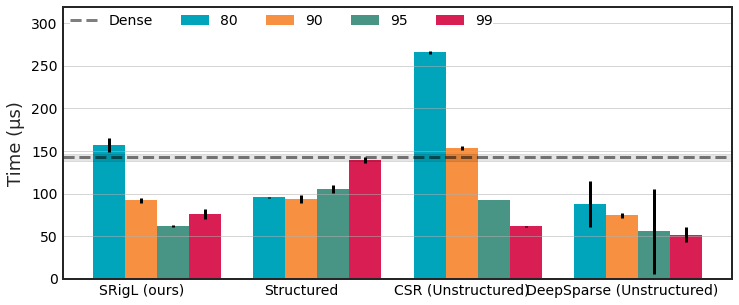

In [ ]:
import re
import pandas as pd
import numpy as np
plt.style.use("./plt_plot_style.mplstyle")


deepsparse_target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    # "DeepSparse - Unstructured - SRigL": "DeepSparse (SRigL)",
    # "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    # "csr only compiled with backend - inductor": "Unstructured",
    "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    "csr only compiled with backend - inductor": "CSR (Unstructured)",
    "DeepSparse - Unstructured": "DeepSparse (Unstructured)",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}

suffixes = ["-deepsparse-final_hector_nice-15", f"final_{_FNAME_SUFFIX}"]

import pickle
# for threads in [1,2,4,8,16]:
for threads in [4,]:
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}-deepsparse-final_hector_nice-15.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)


    data = {
        "sparsity": [],
        "batch_size": [],
        "num_features": [],
        "time": [],
        "std": [],
        "description": [],
        "times":[]
    }
    for measurement in compare._results:
        sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
        sparsity = sparsity_match.groups()[0]

        thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
        threads = thread_match.groups()[0]
        desc = measurement.description
        if desc not in deepsparse_target_descriptions.keys():
            continue
        data["description"].append(deepsparse_target_descriptions[desc])
        data["sparsity"].append(int(sparsity))
        batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
        data["batch_size"].append(int(batch))
        data["num_features"].append(int(num_features))
        data["time"].append(measurement.median*1e6)
        data["times"].append([t*1e6 for t in measurement.times])
        data["std"].append(np.std(measurement.times)*1e6)


    df = pd.DataFrame(data)
    df = df.reset_index()
    df = df.loc[df["batch_size"]==1].reset_index()
    # if threads == "16":

    min_runs = np.inf
    for t in df['times']:
        if len(t)<min_runs:
            min_runs=len(t)
    print(min_runs)
    _DESC_ORDER = list(deepsparse_target_descriptions.values())
    df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
    df = df.sort_values(by="batch_size", ascending=True)
    x = np.arange(4)  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2, _FIG_SIZE[1]))  
    df_one_sample = df.loc[(df["batch_size"]==1) & (df["description"]!="Dense")]
    df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
    for sparsity in [ 80, 90, 95, 99]:
        df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
        offset = width * multiplier
        rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"])
        multiplier += 1
    dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["time"].item()
    std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["std"].item()
    plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
    # plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")
    
    ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
    # _alpha=0.2
    # plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
    # plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
    ax.set_ylabel('Time (\u03bcs)')
    ax.set_xticks(x + width, _DESC_ORDER[:-1])
    # ax.legend(title="Sparsity", loc='upper left', ncol=5)
    # ax.legend(loc='upper left', ncol=5, frameon=True)
    leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
    leg.get_frame().set_linewidth(0.0)
    y_max = df.loc[(df["batch_size"]==1)]["time"].max() 
    y_lim = y_max + y_max*0.2
    # y_lim = dense_time + dense_time * 0.2
    plt.ylim(top=y_lim, bottom=0)
    # plt.ylim(top=200, bottom=0)
    # ax.set_xlim=([0,2])
    ax.margins(0)  
    # plt.tight_layout(pad=0,h_pad=0)
    # plt.grid(axis="y", alpha=0.4)
    plt.grid(axis="y", alpha=0.66)

    fig.show()

    # plt.title(f"{threads} threads")
    # fig.savefig(f"../figs/grouped-bar-threads-{threads}.png", dpi=600, bbox_inches="tight")
    # fig.savefig(f"../figs/grouped-bar-threads-{threads}.pdf", dpi=600, bbox_inches="tight")


In [ ]:
df


sparsity  batch_size  num_features          time          std  \
95         95           1          3072     36.167209     7.155722   
189        80           1          3072     66.409758     7.608274   
188        80           1          3072     96.018100     8.551347   
143        90           1          3072     43.218883     3.936562   
142        90           1          3072     74.157577     7.384433   
..        ...         ...           ...           ...          ...   
145        80        2048          3072   4091.660026   507.042419   
146        80        2048          3072  32193.977386  2771.154095   
147        80        2048          3072  61874.275794  2506.466313   
96         90        2048          3072   8210.071828   813.539853   
0          99        2048          3072   8211.981039   997.327098   

                        description  \
95   SRigL: Struct. + Const. fan-in   
189             SRigL: Struct. only   
188                           Dense   
143  SRigL: Struct. + Const. fan-in   
142                       RigL: CSR   
..                              ...   
145             SRigL: Struct. only   
146                       RigL: CSR   
147  SRigL: Struct. + Const. fan-in   
96                            Dense   
0                             Dense   

                                                 times  
95   [49.483818002045155, 43.286317959427834, 42.01...  
189  [68.66620853543282, 81.38469886034727, 98.4539...  
188  [116.68731458485126, 116.33289977908134, 116.6...  
143  [66.5759714320302, 53.861113265156746, 50.8129...  
142  [74.1732306778431, 74.03820753097534, 74.09465...  
..                                                 ...  
145  [5456.481594592333, 4281.3727632164955, 5051.9...  
146  [32116.779126226902, 32232.029363512993, 32061...  
147  [61490.65587669611, 61845.004092901945, 64001....  
96   [8181.014098227024, 8127.561770379543, 8154.54...  
0    [8181.451819837093, 11451.891157776117, 12030....  

[192 rows x 7 columns]

In [ ]:
## GPU Timings
import pickle
threads = 1
device = "gpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)


[---------------------------------------------------------------------------------------------------------------------------------- Sparsity 99 with 1 threads using compilation strategy inductor and dtype torch.float32 on device cuda. ---------------------------------------------------------------------------------------------------------------------------------]
                     |  Dense benchmark - eager  |  Structured sparsity - eager  |  structured + csr - eager  |  Vmap - eager  |  Fine-grained + structured - eager  |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  Fine-grained + structured with backend inductor
1 threads: -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

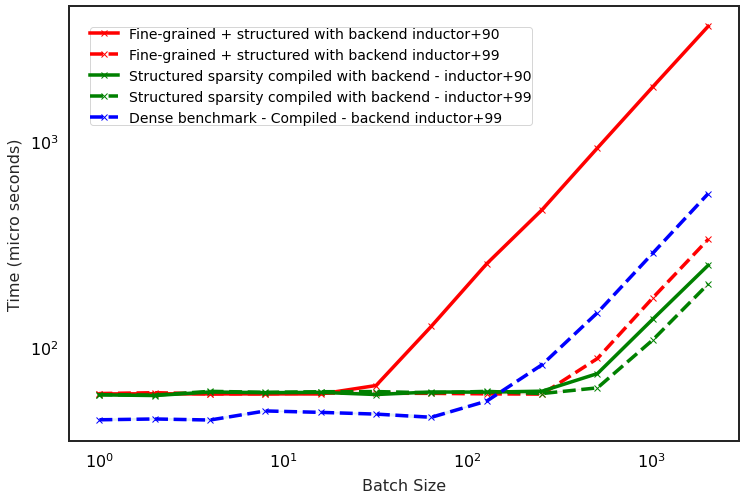

In [ ]:
import re
import pandas as pd
import numpy as np
plt.style.use("../plt_plot_style.mplstyle")
target_descriptions = [
    "Fine-grained + structured with backend inductor",
    # "structured + csr with backend inductor",
    "Dense benchmark - Compiled - backend inductor",
    "Structured sparsity compiled with backend - inductor",
    # "Vmap - eager"
]
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}
for measurement in compare._results:
    sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
    sparsity = sparsity_match.groups()[0]

    thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
    threads = thread_match.groups()[0]
    desc = measurement.description
    if int(sparsity) == 80:
        continue
    if desc not in target_descriptions:
        continue
    if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) !=99:
        continue
    data["description"].append(desc)
    data["sparsity"].append(int(sparsity))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["std"].append(np.std(measurement.times)*1e6)
df = pd.DataFrame(data)
df = df.sort_values(by="batch_size", ascending=True)
fig, ax = plt.subplots(figsize=(12,8))
df = df.loc[df["batch_size"]<=2048]  # TODO: Also sort by desc?
lines = ["solid", "dashed", "dashdot", "dotted"]
colours = ["red", "green", "blue", "orange"]
for i, d in enumerate(df["description"].unique()):
    colour = colours[i]
    for ii, s in enumerate(df["sparsity"].unique()):
        line = lines[ii]
        df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
        # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
        if len(df_slice) > 0:
            ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}+{s}", marker="x", ls=line, color=colour)
            ax.fill_between(
                df_slice["batch_size"],
                df_slice["time"]+df_slice["std"],
                df_slice["time"]-df_slice["std"],
                alpha=0.2
            )
plt.legend()
plt.ylabel("Time (\u03bcs)")
plt.xlabel("Batch Size")
# plt.title(f"{result_type.upper()} Benchmark")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
fig.savefig("gpu_benchmark_v2.png", dpi=400, transparent=False)
